### Setup and Data Downloading

In [2]:
# Command: pip install matplotlib Pillow tensorflow tf-keras-vis numpy scipy

import os
import glob
import shutil
import random
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import collections
import collections.abc
collections.Iterable = collections.abc.Iterable

import numpy as np
from vis.utils import utils
from tf_keras_vis.utils import normalize
from tf_keras_vis.saliency import Saliency

### Loading and Processing Data

In [3]:
dataset_zip = Path('data/train.zip')
images_base = dataset_zip.parent / 'images'
shutil.unpack_archive(dataset_zip, images_base)

cat_files = glob.glob(str(images_base / 'train/cat*.jpg'))
dog_files = glob.glob(str(images_base / 'train/dog*.jpg'))

for folder in ['train/cat', 'train/dog', 'test/cat', 'test/dog']:
    path = images_base / folder
    path.mkdir(parents=True, exist_ok=True)

train_dog_files = random.sample(dog_files, 1000)
train_cat_files = random.sample(cat_files, 1000)

test_dog_files = [f for f in random.sample(dog_files, 100) if f not in train_dog_files]
test_cat_files = [f for f in random.sample(cat_files, 100) if f not in train_cat_files]

for f in train_dog_files:
    shutil.move(f, images_base / 'train/dog')

for f in train_cat_files:
    shutil.move(f, images_base / 'train/cat')

for f in test_dog_files:
    shutil.move(f, images_base / 'test/dog')

for f in test_cat_files:
    shutil.move(f, images_base / 'test/cat')
    
training_dir = r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\images\train'
testing_dir =  r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\images\test'

print(f'Total training dog images: {len(os.listdir(images_base / 'train/dog'))}')
print(f'Total training cat images: {len(os.listdir(images_base / 'train/cat'))}')
print(f'Total test dog images: {len(os.listdir(images_base / 'test/dog'))}')
print(f'Total test cat images: {len(os.listdir(images_base / 'test/cat'))}')

Error: Destination path 'data\images\train\dog\dog.9379.jpg' already exists

### Train Model

In [4]:
# All images will be rescaled by 1./255 with some augmentation applied to training images
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    training_dir,            # This is the source directory for training images
    target_size=(300, 300),  # All images will be resized to 300x300
    batch_size=128,
    class_mode='binary'      # Since you use binary_crossentropy loss, you need binary labels
)

# Flow validation images in batches of 128 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        testing_dir,             # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        class_mode='binary'      # Since you use binary_crossentropy loss, you need binary labels
)

#model architecture
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. 
    # It will contain a value from 0-1 where 0 for 1 class ('dog') and 1 for the other ('cat')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model compilation
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# model training
history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data = validation_generator
)

Found 2000 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


c:\Users\joaov_zm1q2wh\Documents\projects\semantic_ai\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\joaov_zm1q2wh\Documents\projects\semantic_ai\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5151 - loss: 0.6954

c:\Users\joaov_zm1q2wh\Documents\projects\semantic_ai\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5105 - loss: 0.6968 - val_accuracy: 0.5056 - val_loss: 0.6927
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5210 - loss: 0.6921 - val_accuracy: 0.5944 - val_loss: 0.6865
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5565 - loss: 0.6850 - val_accuracy: 0.5444 - val_loss: 0.6852
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5755 - loss: 0.6827 - val_accuracy: 0.5889 - val_loss: 0.6662
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5805 - loss: 0.6725 - val_accuracy: 0.6889 - val_loss: 0.6507
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5800 - loss: 0.6720 - val_accuracy: 0.5889 - val_loss: 0.6681
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5950 - loss: 0.6649 - val_accuracy: 0.5889 - val_loss: 0.6543
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6190 - loss: 0.6530 - val_accuracy: 0.5833 - val_loss: 0.6

In [5]:
# Recuperar histórico de treino
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

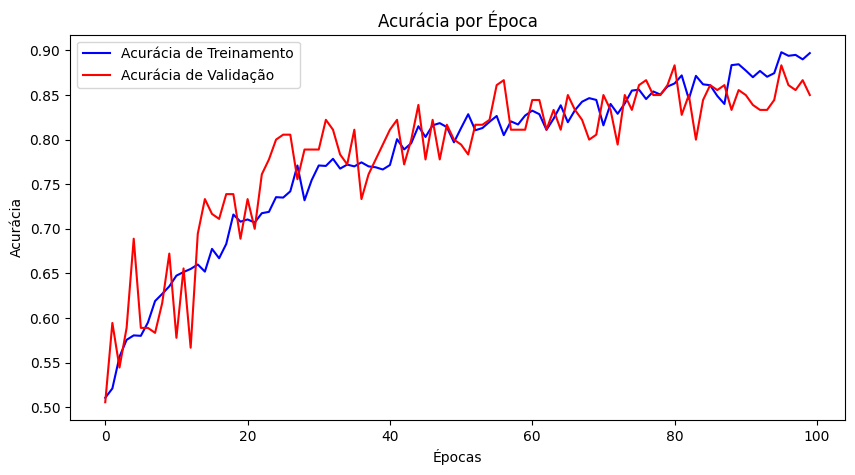

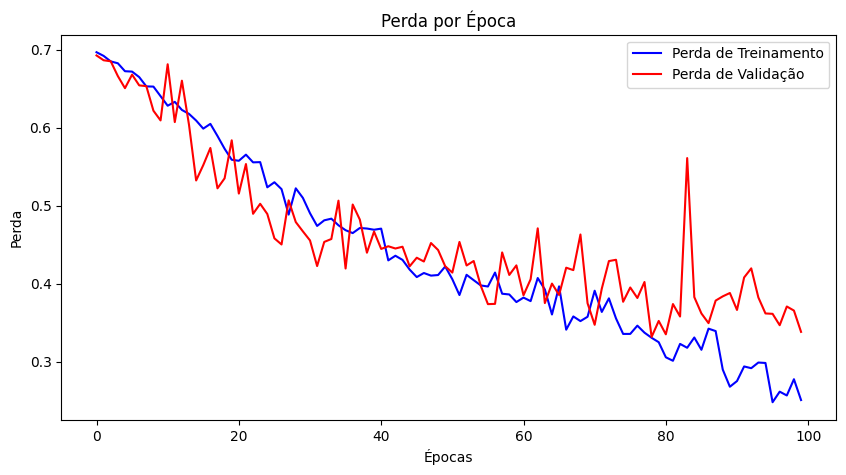

In [6]:
epochs = range(len(acc))

# Acurácia
plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'b', label='Acurácia de Treinamento')
plt.plot(epochs, val_acc, 'r', label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Perda
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'b', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'r', label='Perda de Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

### Acurácia por Época

- Tendência geral: Ambas as curvas apresentam um crescimento consistente da acurácia, partindo de aproximadamente 0.50-0.52 (50%) e atingindo valores entre 0.85-0.90 (85-90%) ao final do treinamento.
- Comportamento inicial (épocas 0-40): Crescimento rápido e acentuado da acurácia, com a curva de validação (vermelho) apresentando maior volatilidade (oscilações mais pronunciadas) que a de treinamento (azul).
- Comportamento intermediário/final (épocas 40-100): As curvas convergem e se estabilizam em torno de 85-90%, com oscilações moderadas. As duas curvas se entrelaçam frequentemente, sem um gap consistente.
- Volatilidade da validação: A acurácia de validação apresenta picos e quedas mais acentuados ao longo de todo o treinamento, o que é esperado, pois o conjunto de validação é menor e mais sensível a variações.

### Perda por Época

- Tendência geral: Ambas as curvas (treinamento em azul e validação em vermelho) apresentam uma redução consistente da perda ao longo das épocas, partindo de aproximadamente 0.70 e chegando a valores entre 0.25-0.35 ao final.
- Comportamento inicial (épocas 0-40): Há uma queda acentuada e relativamente suave na perda, indicando que o modelo está aprendendo rapidamente os padrões dos dados.
- Comportamento intermediário/final (épocas 40-100): A perda continua diminuindo, mas de forma mais gradual, com maior oscilação na curva de validação.
- Gap entre treinamento e validação: A partir da época 40, nota-se que a perda de validação (vermelho) se mantém consistentemente acima da perda de treinamento (azul), e essa diferença aumenta ligeiramente nas épocas finais. Isso sugere um início de overfitting (sobreajuste), onde o modelo está se ajustando melhor aos dados de treinamento do que aos dados de validação.

### Resumo:
O modelo está aprendendo efetivamente, com redução consistente da perda e aumento da acurácia, finalizando com ~85-90%, o que indica um desempenho razoável. Não há sinais de "underfitting", pois o modelo consegue aprender os padrões dos dados.

O gap crescente entre as perdas de treinamento e validação (especialmente visível após a época 60) sugere que o modelo pode estar começando a memorizar os dados de treinamento em vez de generalizar. As oscilações na curva vermelha de acurácia sugerem que o conjunto de validação pode ser pequeno ou que o modelo é sensível a variações nos dados

### Melhorias:

No geral, o treinamento parece estar progredindo adequadamente, mas há espaço para otimização para melhorar a generalização do modelo.

Melhorias mapeadas:
- Considerar early stopping (parada antecipada) em torno da época 60-70, quando a perda de validação começa a se estabilizar
- Aplicar técnicas de regularização (dropout, weight decay) para reduzir o overfitting
- Avaliar se o conjunto de validação é representativo e suficientemente grande
- Considerar data augmentation para aumentar a diversidade dos dados de treinamento

In [29]:
testing_dir_dog = r'C:\Users\joaov_zm1q2wh\Documents\projects\semantic_ai\essential_topics_in_semantic_ai\week_5\src\data\images\test\dog'

# random_image = random.sample(os.listdir(testing_dir_dog), 1)[0]
# img_path = os.path.join(testing_dir_dog, random_image)

specific_image = 'dog.796.jpg'
img_path = os.path.join(testing_dir_dog, specific_image)


img = tf.keras.preprocessing.image.load_img(img_path, target_size=(300, 300))

x = img_to_array(img)          # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

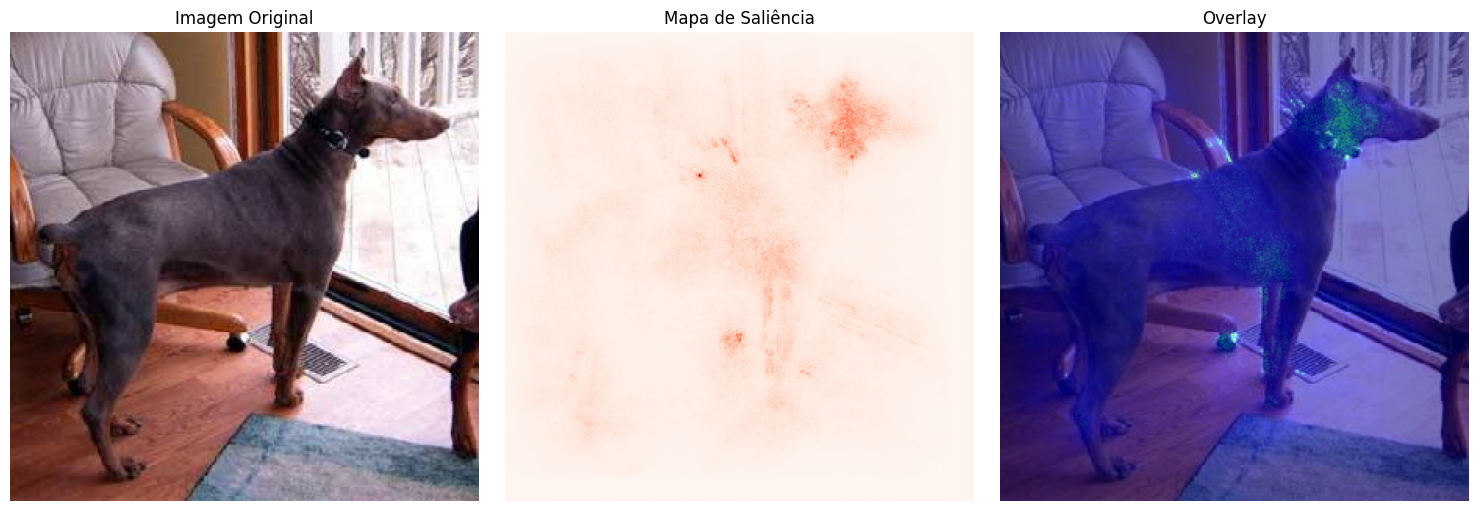

In [ ]:
# Ajustar modelo e gerar mapa de saliência (trocar a última camada pela camada linear)
layer_idx = utils.find_layer_idx(model, model.layers[-1].name)
model.layers[-1].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

score = CategoricalScore([0])           # classe-alvo (ajuste se necessário)
saliency = Saliency(model, clone=False) # Cria objeto Saliency

saliency_map = saliency(score, x)
saliency_map = normalize(saliency_map)

# --- Plotar imagem, mapa e overlay ---
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Imagem original
ax[0].imshow(img)
ax[0].set_title("Imagem Original")
ax[0].axis('off')

# 2Mapa de saliência puro
ax[1].imshow(saliency_map[0], cmap='Reds')
ax[1].set_title("Mapa de Saliência")
ax[1].axis('off')

# Overlay (imagem + saliência)
ax[2].imshow(img)
ax[2].imshow(saliency_map[0], cmap='jet', alpha=0.5)
ax[2].set_title("Overlay")
ax[2].axis('off')

plt.tight_layout()
plt.show()

Se reparar bem, a cada execução o mapa muda. O motivo de o mapa de saliência está nos dois parâmetros <code>smooth_samples</code> e <code>smooth_noise</code>.

Esses parâmetros ativam o método conhecido como <b>SmoothGrad</b> (uma técnica para suavizar os mapas de saliência), que funciona adicionando ruído aleatório à imagem várias vezes e tirando a média dos gradientes resultantes.

Nesse caso, a cada execução:

- São geradas 20 cópias da imagem com ruido (smooth_samples=20)
- Cada cópia recebe um ruído diferente (smooth_noise=0.2 define a intensidade)
- Calcula o gradiente de cada uma
- Faz a média para reduzir o ruído visual e realçar as áreas mais estáveis de atenção

Como o ruído é aleatório, o resultado muda levemente toda vez, mas a essência da imagem se mantém.

Podemos fixar a seed, por exemplo adicionando isso antes de gerar o mapa:

```python
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
```

Também é possível gerar mapas determinísticos, usando o gradiente puro:

```python
saliency_map = saliency(score, x)
```



In [18]:
### ANTES
testing_dir_dog = r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\images\test\cat'
specific_image = 'cat.1304.jpg'
img_path = os.path.join(testing_dir_dog, specific_image)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(300, 300))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

layer_idx = utils.find_layer_idx(model, model.layers[-1].name)
model.layers[-1].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

np.random.seed(42)
tf.random.set_seed(42)

score = CategoricalScore(0)

# Gradient
saliency_grad = Saliency(model, clone=False)
saliency_map_grad = saliency_grad(score, x)
saliency_map_grad = normalize(saliency_map_grad)

# SmoothGrad
saliency_smooth = Saliency(model, clone=False)
saliency_map_smooth = saliency_smooth(score, x, smooth_samples=20, smooth_noise=0.20)
saliency_map_smooth = normalize(saliency_map_smooth)

# Guided Backprop
saliency_guided = Saliency(model, clone=False, model_modifier=None)
saliency_map_guided = saliency_guided(score, x)
saliency_map_guided = normalize(saliency_map_guided)

fig, axs = plt.subplots(1, 4, figsize=(20, 7))

axs[0].imshow(img)
axs[0].set_title('Imagem Original')
axs[0].axis('off')

axs[1].imshow(saliency_map_grad[0], cmap='jet')
axs[1].set_title('Gradient')
axs[1].axis('off')

axs[2].imshow(saliency_map_smooth[0], cmap='jet')
axs[2].set_title('SmoothGrad')
axs[2].axis('off')

axs[3].imshow(saliency_map_guided[0], cmap='jet')
axs[3].set_title('Guided BackProp')
axs[3].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

### Análise da Comparação:

Gradient: Este mapa é o mais "ruidoso". Ele mostra todas as áreas que qualquer influência (positiva ou negativa) na decisão, resultando em um mapa difuso.

SmoothGrad: A média de gradientes com ruído limpa o mapa significativamente, focando melhor nas áreas que consistentemente contribuem para a decisão.

Guided BackProp: Este método é visualmente o mais nítido. Ele modifica a retropropagação para mostrar apenas as características que têm uma influência positiva na ativação da classe. O resultado é um mapa muito focado nos contornos e texturas exatos que o modelo usou para identificar a classe.